In [56]:
import tensorflow as tf
from keras.layers import Activation,Dropout,Input,MaxPooling2D,SeparableConv2D,UpSampling2D,concatenate
from keras.preprocessing.image import img_to_array
from keras.applications import VGG16
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import glob
import random

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
dataset = "drive/My Drive/cancer cell-dataset/test_dataset/images//"
img_height = 128
img_width = 128
img_channels = 3

In [36]:
data = []
for file in glob.glob(dataset+"*"):
    data.append(file)


In [37]:
mask=[]
for a in data:
  if "mask" in a:
    pass
  else:
    a=a.split(".")[0]
    a=a+"_mask.jpg"
    mask.append(a)
mask.sort()
mask[1]

'drive/My Drive/cancer cell-dataset/test_dataset/images/BloodImage_00001_mask.jpg'

In [38]:
images=[]
for i in data:
  if "mask" not in i:
    images.append(i)
images.sort()
images[1]

'drive/My Drive/cancer cell-dataset/test_dataset/images/BloodImage_00001.jpg'

In [39]:
def diceCoeff(y_true,y_pred):
    intersection = np.logical_and(y_true,y_pred)
    union = np.logical_or(y_true,y_pred)
    result = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection))
    return 1-result

In [40]:
X = np.zeros((len(images),128,128,3),dtype=np.uint8)
Y = np.zeros((len(mask),128,128,1),dtype=np.bool)
print("X shape",X.shape)
print("Y shape",Y.shape)

X shape (35, 128, 128, 3)
Y shape (35, 128, 128, 1)


In [41]:
for n,id_ in tqdm(enumerate(images),total=len(images)):
    img = cv2.imread(id_)
    img = cv2.resize(img,(img_height,img_width))
    X[n] = img

100%|██████████| 35/35 [00:00<00:00, 124.44it/s]


In [42]:
for n,mask_file in tqdm(enumerate(mask), total = len(mask)):
    mask = cv2.imread(mask_file,0)
    mask = np.expand_dims(cv2.resize(mask,(img_height,img_width)),axis=-1)
    Y[n] = mask

100%|██████████| 35/35 [00:00<00:00, 217.44it/s]


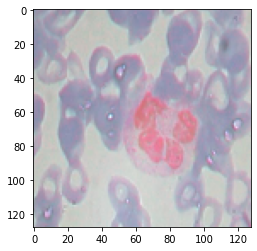

In [43]:
plt.imshow(X[0])

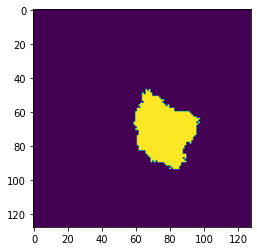

In [44]:
plt.imshow(np.squeeze(Y[0]))

In [57]:
def unets(pretrained=None,input_shape=(128,128,3)):
    inputs_img = Input(input_shape)
    conv1 = SeparableConv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(inputs_img)
    conv1 = SeparableConv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = SeparableConv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = SeparableConv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = SeparableConv2D(256,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = SeparableConv2D(256,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = SeparableConv2D(512,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = SeparableConv2D(512,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.25)(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(drop4)
    
    conv5 = SeparableConv2D(1024,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    conv5 = SeparableConv2D(1024,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.25)(conv5)
    
    up6 = SeparableConv2D(512,(2,2),activation='relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6],axis=3)
    conv6 = SeparableConv2D(512,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = SeparableConv2D(512,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv6)
    
    up7 = SeparableConv2D(256,(2,2),activation='relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7],axis=3)
    conv7 = SeparableConv2D(256,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = SeparableConv2D(256,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv7)
    
    up8 = SeparableConv2D(128,(2,2),activation='relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8],axis=3)
    conv8 = SeparableConv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = SeparableConv2D(128,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv8)
    
    up9 = SeparableConv2D(64,(2,2),activation='relu',padding='same',kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9],axis=3)
    conv9 = SeparableConv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = SeparableConv2D(64,(3,3),activation='relu',padding='same',kernel_initializer='he_normal')(conv9)
    
    conv10 = SeparableConv2D(1, (1,1), activation = 'sigmoid')(conv9)
    model = Model(inputs = [inputs_img], outputs = [conv10])
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5)])
#     print(model.summary())
    return model

In [59]:
input_shape = (128,128,3)
model = unets(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d_68 (SeparableC (None, 128, 128, 64) 283         input_5[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_69 (SeparableC (None, 128, 128, 64) 4736        separable_conv2d_68[0][0]        
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 64, 64, 64)   0           separable_conv2d_69[0][0]        
____________________________________________________________________________________________

In [47]:
modelcheckpoint = ModelCheckpoint('classifier1.h5',monitor='val_loss',verbose=1,mode='min',save_best_only=True)
# earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5,verbose = 1,restore_best_weights = True)
results = model.fit(X, Y, validation_split=0.1,
                    batch_size=2, epochs=50, 
                    )
model.save("1.h5")

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.6930 - accuracy: 0.4614 - auc: 0.4978 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 9.6416e-05 - val_loss: 0.6889 - val_accuracy: 0.9501 - val_auc: 0.2940 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00
Epoch 2/50
16/16 [==============================] - 17s 1s/step - loss: 0.6876 - accuracy: 0.9431 - auc: 0.4233 - sensitivity_at_specificity: 0.0442 - specificity_at_sensitivity: 0.0000e+00 - val_loss: 0.6832 - val_accuracy: 0.9501 - val_auc: 0.4995 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00
Epoch 3/50
16/16 [==============================] - 17s 1s/step - loss: 0.6814 - accuracy: 0.9453 - auc: 0.4617 - sensitivity_at_specificity: 0.0483 - specificity_at_sensitivity: 0.0860 - val_loss: 0.6745 - val_accuracy: 0.9501 - val_auc: 0.4817 - val_sensitivity_at_specificity: 0.0015 - val_specificity_at_sensitiv

In [48]:
def predict_mask(img):
    plt.figure(figsize=(20,20))
    img = cv2.imread(img)
    img = cv2.resize(img,(128,128))
    plt.subplot(131)
    plt.imshow(img)
    # plt.show()
    img1 = img_to_array(img)
    img1 = np.expand_dims(img1,axis=0)
    pred = model.predict(img1)
    pred = (pred > 0.5).astype(np.uint8)
    image=(pred[0]*255).astype(np.uint8)
    edged = cv2.Canny(image, 30, 200)
    contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plt.subplot(132)
    plt.imshow(cv2.polylines(img.copy(),contours,True,(255,254,0)))
    plt.subplot(133)
    plt.imshow(np.squeeze(pred[0]),cmap="seismic")

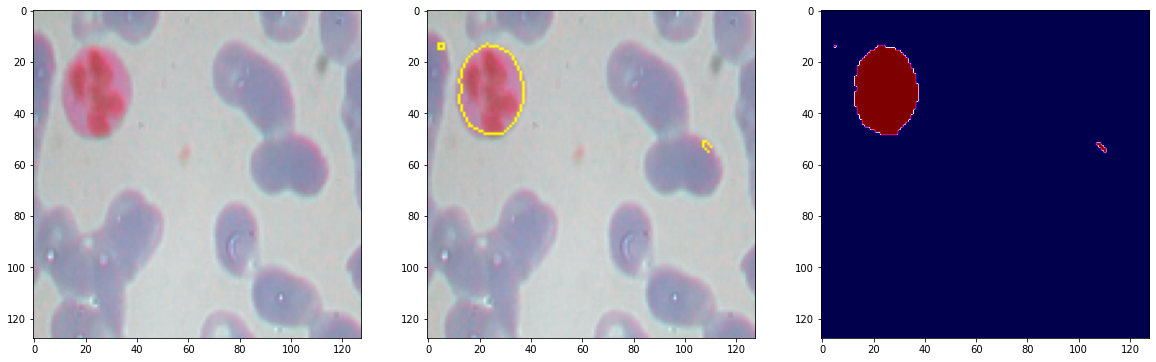

In [49]:
predict_mask("drive/My Drive/cancer cell-dataset/test_dataset/BloodImage_00143.jpg")

In [50]:
preds_train = model.predict(X, verbose=1)

2/2 [==============================] - 5s 407ms/step


In [51]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)

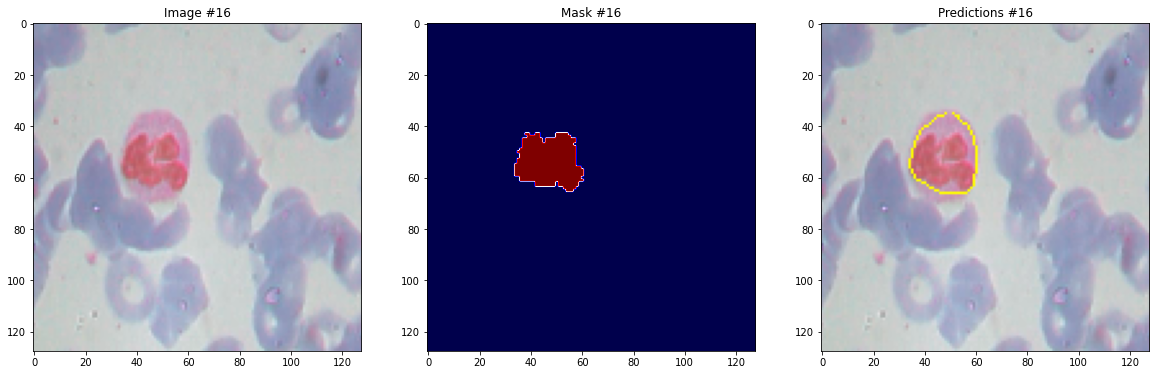

In [52]:
# Ploting our predicted masks
ix = random.randint(0, len(X))
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
plt.imshow(X[ix])
plt.title("Image #{}".format(ix))

# Our original training mask
plt.subplot(132)
plt.imshow(np.squeeze(Y[ix]),cmap='seismic')
plt.title("Mask #{}".format(ix))

# Prediction on training images
plt.subplot(133)
image=(preds_train_t[ix]*255).astype(np.uint8)
edged = cv2.Canny(image, 30, 200)
contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plt.imshow(cv2.polylines(X[ix].copy(),contours,False,(255,254,0)))
plt.title("Predictions #{}".format(ix))
plt.show()


In [53]:
# plt.imshow(preds_train_t[ix])

In [54]:
files=[]
for file in glob.glob("drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/*"):
    files.append(file)

['drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00003.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00056.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00012.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00069.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00009.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00006.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00032.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00072.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00014.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00018.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00035.jpg', 'drive/My Drive/cancer cell-dataset/test_dataset/JPEGImages/BloodImage_00047.jpg', 'dr

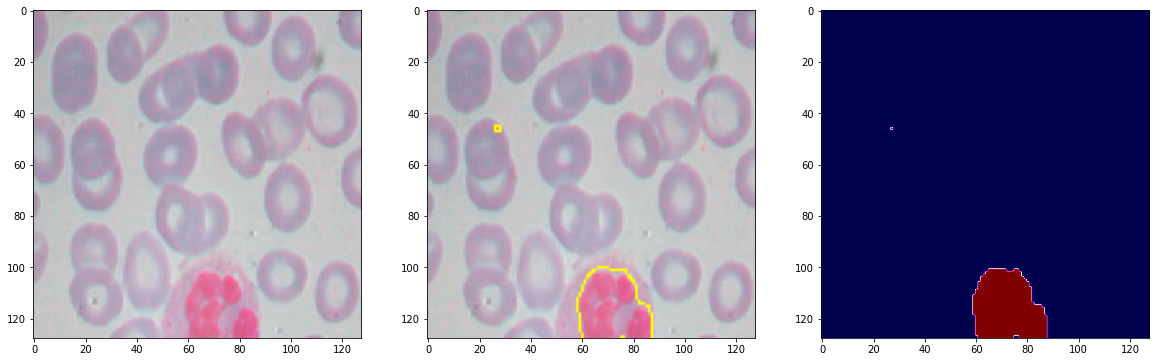

In [55]:
ix = random.randint(0,len(files))
print(files)
predict_mask(files[ix])